**Step 1: Data Preprocessing**


In [20]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)


In [21]:
#Load and View Dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [22]:
# Check for missing values
missing_summary = df.isnull().sum()
print(" Missing Values in Dataset:\n", missing_summary)

# If missing values are found, handle them
if missing_summary.any():
    print("\n Missing values detected! Applying preprocessing...")

    # Option 1: Fill with mean (recommended for continuous numerical features)
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Option 2 (Alternative): Drop rows with missing values
    # df.dropna(inplace=True)

    print("\nMissing values have been handled.")
else:
    print("\n No missing values found.")


 Missing Values in Dataset:
 mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
diagnosis                  0
dtype: int64

 No missing values found.


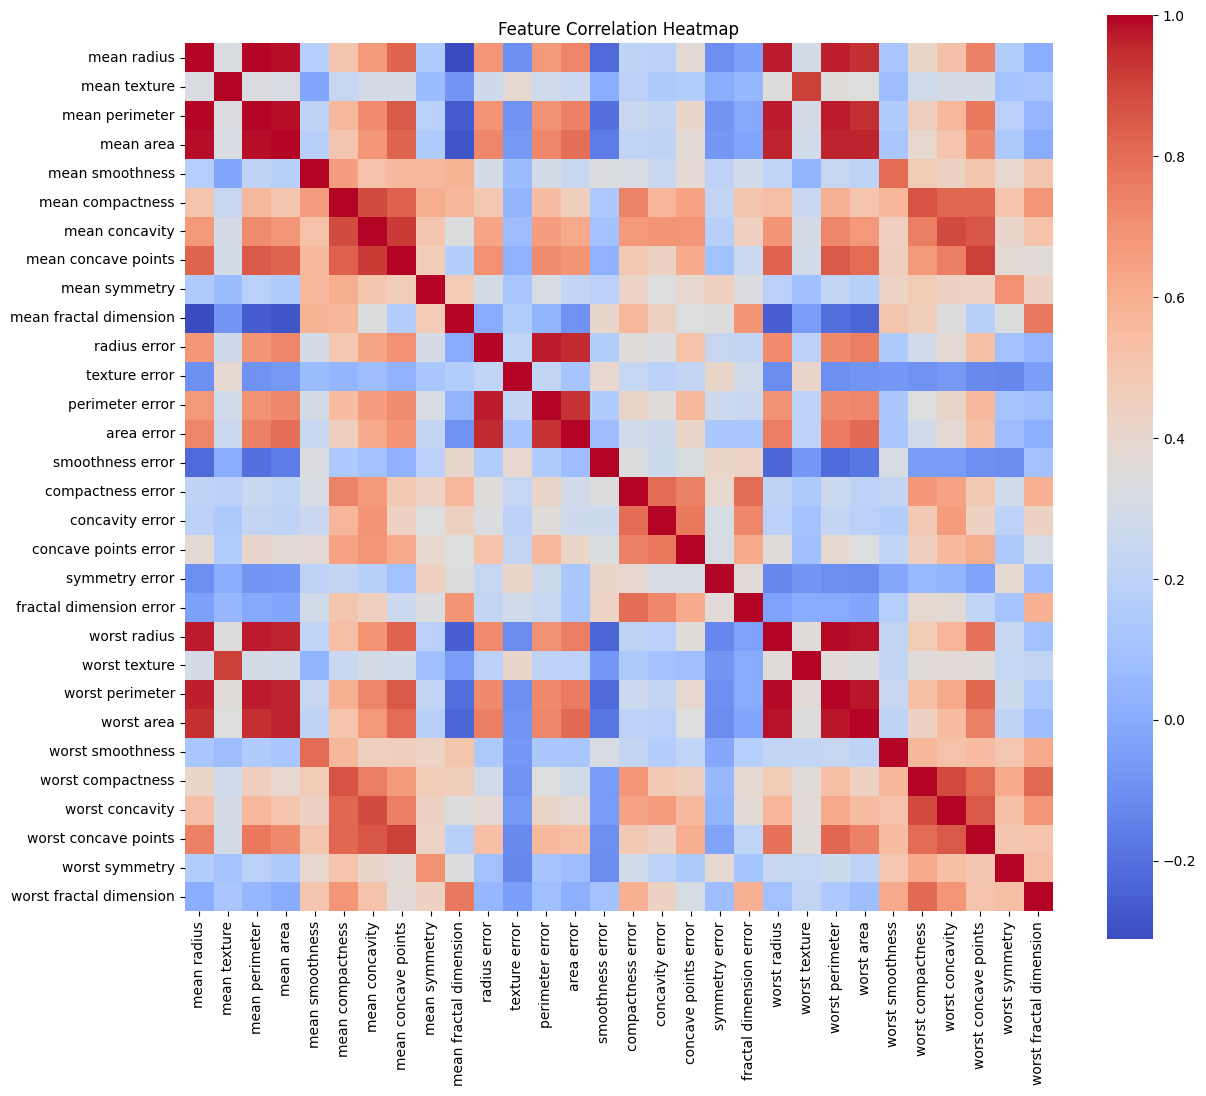

In [23]:
#Correlation Heatmap
plt.figure(figsize=(14, 12))
corr_full = df.drop(columns=['diagnosis']).corr()
sns.heatmap(corr_full, cmap='coolwarm', square=True, cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()


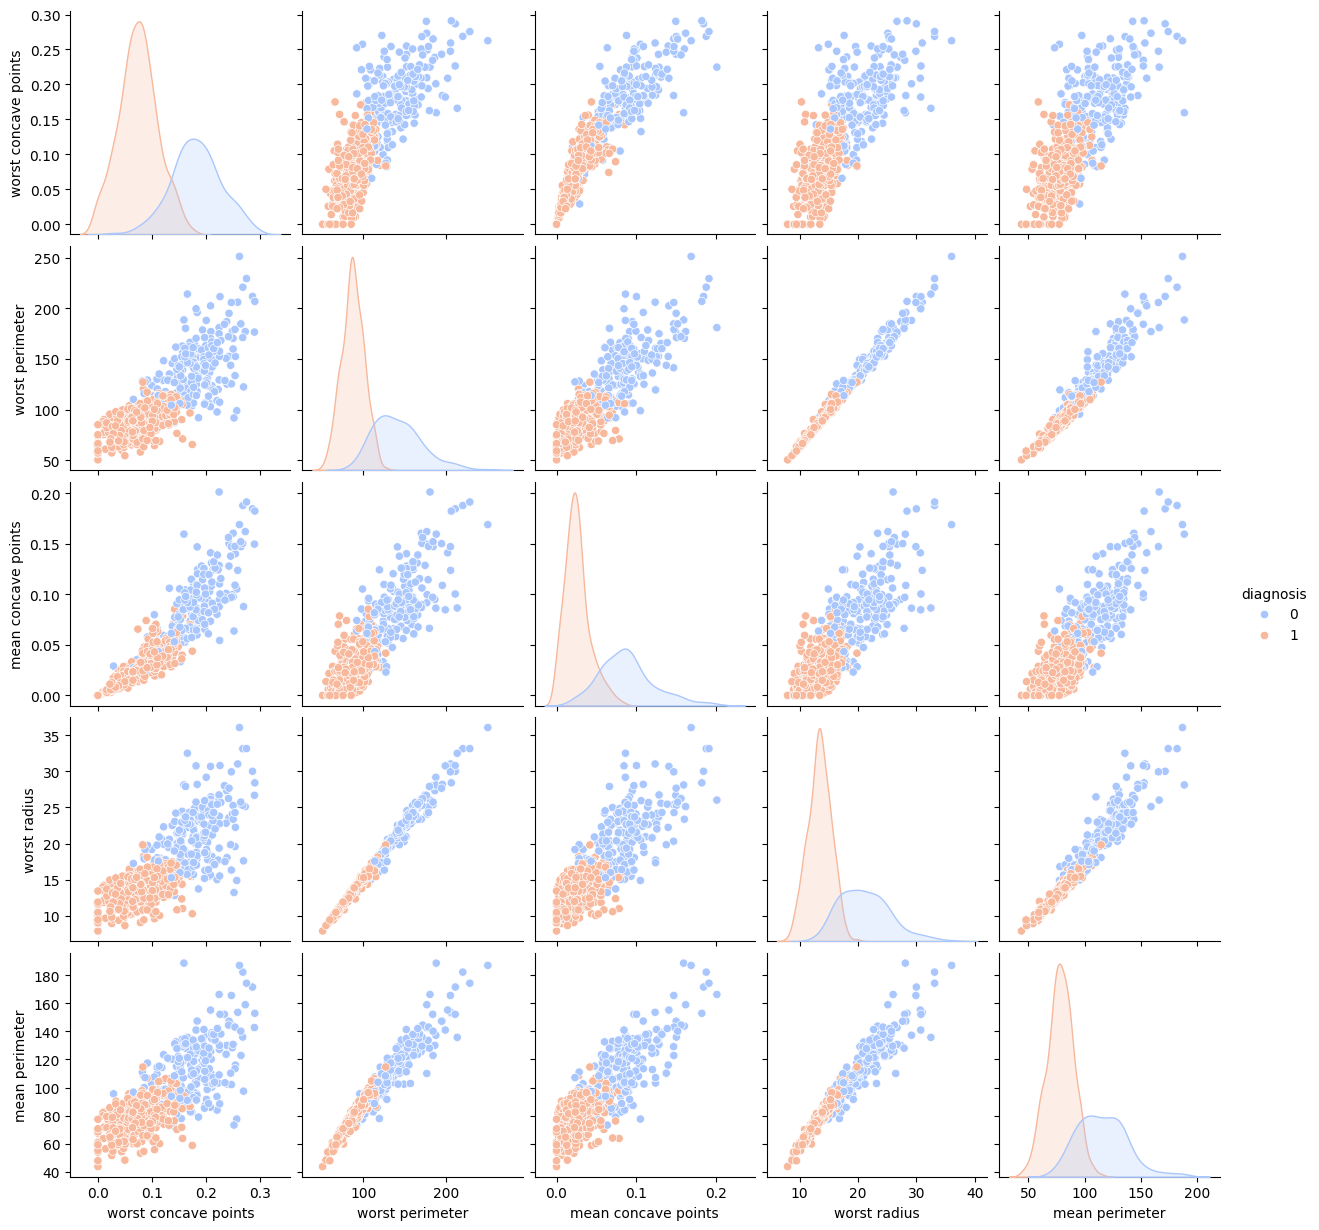

In [24]:
# Top Correlated Feature Pairplots
top_corr_features = df.corr()['diagnosis'].abs().sort_values(ascending=False)[1:6].index.tolist()
sns.pairplot(df, vars=top_corr_features, hue="diagnosis", palette="coolwarm")
plt.show()



In [25]:
#Feature-Target Split and Scaling
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


In [26]:
#SelectKBest Feature Selection
k = min(12, X.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled_df, y)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
X_selected_named = X_scaled_df[selected_features]

feature_scores = selector.scores_[selected_indices]
feature_score_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

print("\n Top Selected Features by SelectKBest:")
print(feature_score_df)



 Top Selected Features by SelectKBest:
                 Feature       Score
11  worst concave points  964.385393
7        worst perimeter  897.944219
5    mean concave points  861.676020
6           worst radius  860.781707
1         mean perimeter  697.235272
8             worst area  661.600206
0            mean radius  646.981021
2              mean area  573.060747
4         mean concavity  533.793126
10       worst concavity  436.691939
3       mean compactness  313.233079
9      worst compactness  304.341063


In [27]:
#Correlation Filtering
corr_matrix = X_selected_named.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.99)]

final_selected_features = [f for f in selected_features if f not in to_drop_corr]

print("\n Features Removed Due to Correlation > 0.99:")
print(to_drop_corr if to_drop_corr else "None")

print("\nFinal Selected Features After Correlation Filtering:")
print(final_selected_features)




 Features Removed Due to Correlation > 0.99:
['mean perimeter', 'worst perimeter']

Final Selected Features After Correlation Filtering:
['mean radius', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'worst radius', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [28]:
#Final Feature Set and Split
X_final_selected = X_scaled_df[final_selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_final_selected, y, test_size=0.2, stratify=y, random_state=42)


**Step 2: Train Baseline Models**

In [29]:
#Define Baseline Models & their Hyperparameter Grids
from sklearn.model_selection import StratifiedKFold

# Define models and their hyperparameters
baseline_models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=5000),
        "params": {"C": [0.01, 0.1, 1, 10]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [3, 5, 10, None], "criterion": ["gini", "entropy"]}
    }
}

baseline_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [30]:
#Grid Search CV with Performance Reporting
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Evaluate each baseline model
for name, config in baseline_models.items():
    print(f"\n Tuning and evaluating {name}...")

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    print(f" Best Parameters for {name}: {grid.best_params_}")

    # Predict on test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Cross-validation score
    cv_score = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy').mean()

    # Store results
    baseline_results[name] = {
        'Best Params': grid.best_params_,
        'CV Accuracy': cv_score,
        'Test Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'AUC': auc
    }

    print(f"\n Performance on Test Set for {name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}" if auc is not None else "AUC: Not applicable")




 Tuning and evaluating Logistic Regression...
 Best Parameters for Logistic Regression: {'C': 1}

 Performance on Test Set for Logistic Regression:
Accuracy:  0.9386
Precision: 0.9333
Recall:    0.9722
F1 Score:  0.9524
AUC:       0.9864

 Tuning and evaluating Decision Tree...
 Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3}

 Performance on Test Set for Decision Tree:
Accuracy:  0.9386
Precision: 0.9333
Recall:    0.9722
F1 Score:  0.9524
AUC:       0.9732


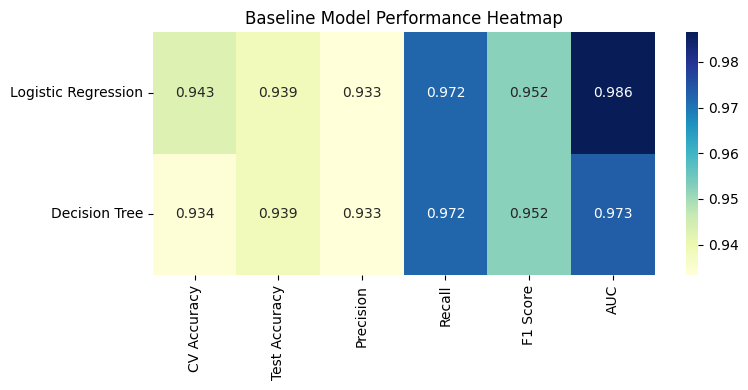

In [31]:
#Visualize Baseline Model Results
# Convert results to DataFrame
baseline_df_full = pd.DataFrame(baseline_results).T

# Keep only numeric columns for heatmap
baseline_df_numeric = baseline_df_full.drop(columns=['Best Params'])

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(baseline_df_numeric.astype(float), annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Baseline Model Performance Heatmap")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




**Step 3: Train & Evaluate Further Models + Ensemble**

In [32]:
# Define All Models & Param Grids
models = {
    "Linear SVC": LinearSVC(max_iter=10000),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression()
}

param_grids = {
    "SVC": {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']},
    "KNN": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10]}
}


In [33]:
#Train Models with GridSearchCV
best_models = {}

for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f" Best parameters for {name}: {grid.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)
    best_models[name] = best_model


🔧 Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🔧 Best parameters for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
🔧 Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
🔧 Best parameters for Logistic Regression: {'C': 10}


In [34]:
#Train Ensemble Model
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', best_models['Logistic Regression']),
        ('rf', best_models['Random Forest']),
        ('svc', best_models['SVC'])
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
best_models['Ensemble Voting'] = voting_clf


**Step 4: Evaluate & Compare Results**

In [35]:
#Cross-Validation for Ensemble
cv_scores = cross_val_score(voting_clf, X_final_selected, y, cv=5, scoring='accuracy')
print(f"\n Voting Classifier CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



📈 Voting Classifier CV Accuracy: 0.9508 ± 0.0275



Linear SVC Confusion Matrix:
 [[39  3]
 [ 5 67]]
Linear SVC Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.96      0.93      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114


SVC Confusion Matrix:
 [[38  4]
 [ 1 71]]
SVC Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


KNN Confusion Matrix:
 [[38  4]
 [ 4 68]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
          

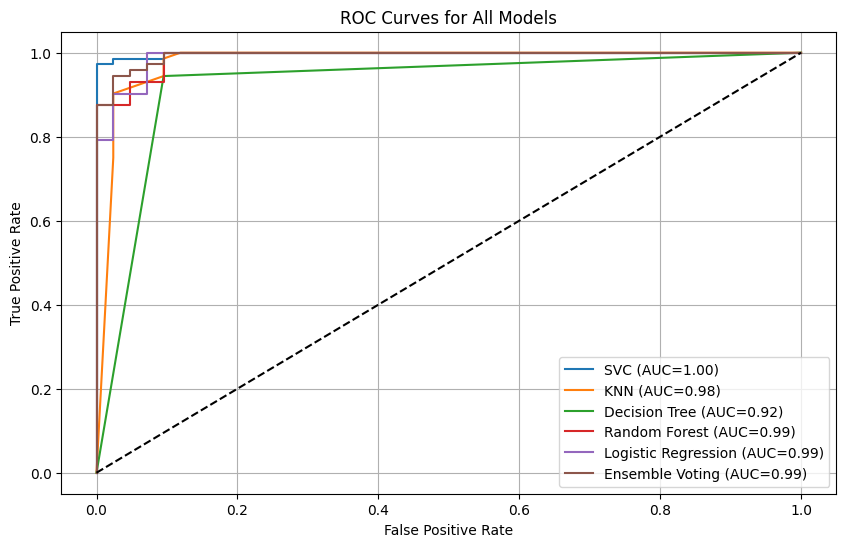

In [36]:
#Evaluate All Models on Test Set
results = {}
plt.figure(figsize=(10, 6))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {
        "Accuracy": acc,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-score": report['1']['f1-score'],
        "AUC": auc
    }

    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid()
plt.show()



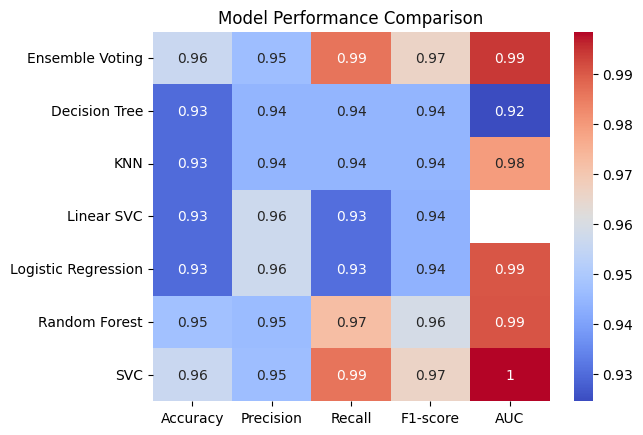

In [37]:
#Visual Comparison: Heatmap
results_df = pd.DataFrame(results).T
results_df = results_df.reindex(sorted(results_df.index, key=lambda x: (x != 'Ensemble Voting', x)))
sns.heatmap(results_df, annot=True, cmap="coolwarm")
plt.title("Model Performance Comparison")
plt.show()
